### Bài thực hành 2 
Xây dựng mô hình phân cụm K-means trên tập dữ liệu mua sắm tại siêu thị. Dữ liệu lấy tại 
https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

1. Import thư viện & đọc dữ liệu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv("Dataset/OnlineRetail.csv", encoding="latin1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


2. Tiền xử lý dữ liệu

In [3]:
# Loại bỏ dữ liệu thiếu CustomerID
df = df.dropna(subset=['CustomerID'])

# Loại bỏ Quantity và UnitPrice âm hoặc 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    format='%d-%m-%Y %H:%M',
    errors='coerce'
)
df = df.dropna(subset=['InvoiceDate'])

3. Tạo bảng RFM

In [4]:
snapshot_date = df['InvoiceDate'].max()

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'TotalQuantity', 'AvgUnitPrice']
rfm.head()

,CustomerID,Recency,Frequency,TotalQuantity,AvgUnitPrice
0,12346.0,325,1,74215,1.040000
1,12347.0,1,7,2458,2.644011
2,12348.0,74,4,2341,5.764839
3,12349.0,18,1,631,8.289041
4,12350.0,309,1,197,3.841176


4. Chuẩn hóa dữ liệu

In [5]:
features = ['Recency','Frequency','TotalQuantity','AvgUnitPrice']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[features])

5. Elbow Method để chọn K

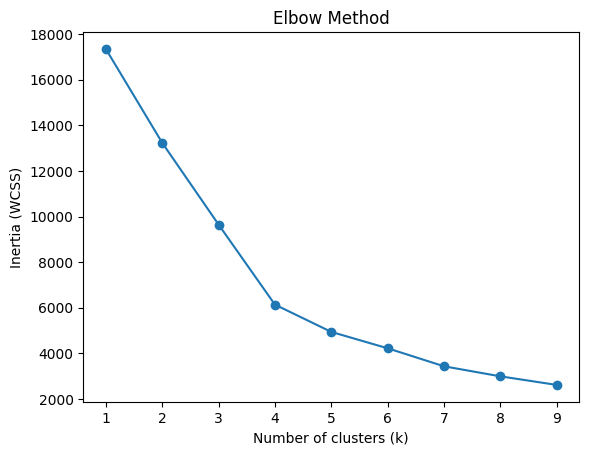

In [6]:
inertia = []
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")
plt.show()

6. Huấn luyện mô hình K-means với k tối ưu

In [7]:
k_opt = 4

kmeans = KMeans(n_clusters=k_opt, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(X_scaled)
rfm.head()

,CustomerID,Recency,Frequency,TotalQuantity,AvgUnitPrice,Cluster
0,12346.0,325,1,74215,1.040000,1
1,12347.0,1,7,2458,2.644011,0
2,12348.0,74,4,2341,5.764839,0
3,12349.0,18,1,631,8.289041,0
4,12350.0,309,1,197,3.841176,2


7. Giảm chiều PCA để trực quan hóa

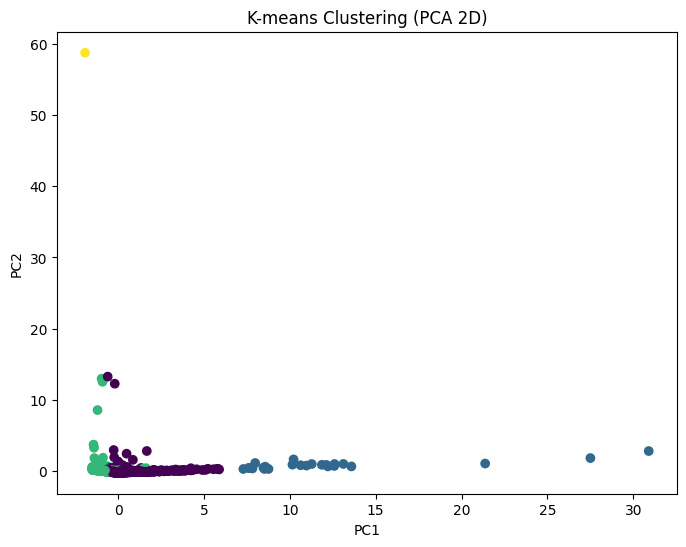

In [8]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=rfm['Cluster'], cmap='viridis')
plt.title("K-means Clustering (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

8. Phân tích nhanh các cụm

In [11]:
rfm.groupby('Cluster')[features].mean()

,Recency,Frequency,TotalQuantity,AvgUnitPrice
Cluster,,,,
0,40.226906,4.703968,1120.187229,3.579170
1,18.500000,68.250000,51890.833333,4.009312
2,245.432383,1.580497,283.999080,5.248824
3,84.000000,1.000000,1.000000,2033.100000


9. Silhouette Score kiểm tra chất lượng phân cụm

In [10]:
sil_score = silhouette_score(X_scaled, rfm['Cluster'])
sil_score

0.5828794239816659